## **PROJECT - NOTEBOOK #3: API - USAJOBS**

---

### **Setting Environment**

In [1]:
import os 
print(os.getcwd())

try:
    os.chdir("../../project_etl")

except FileNotFoundError:
    print("""
        FileNotFoundError - The directory may not exist or you might not be in the specified path.
        If this has already worked, do not run this block again, as the current directory is already set to project_etl.
        """)
    
print(os.getcwd())

d:\U\FIFTH SEMESTER\ETL\project_etl\notebooks
d:\U\FIFTH SEMESTER\ETL\project_etl


### **Importing modules and libraries**

In [2]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

### **API Connection**

In [3]:
API_KEY = "M5yC0zhQRl+OPdavWX7qKNpgpMILvk1ZxKqTMXpUgxU="
EMAIL = "sebasbelmosdev@gmail.com"  
BASE_URL = "https://data.usajobs.gov/api/search"
HEADERS = {
    "Host": "data.usajobs.gov",
    "User-Agent": EMAIL,
    "Authorization-Key": API_KEY
}

### **API Data Extraction**

In [4]:
def fetch_usajobs_data(query_params=None, max_pages=20, page_size=500):
    all_data = []
    page_number = 1
    
    session = requests.Session()
    retries = Retry(total=3, backoff_factor=1, status_forcelist=[429, 500, 502, 503, 504])
    session.mount("https://", HTTPAdapter(max_retries=retries))

    while page_number <= max_pages:
        params = {
            "Page": page_number,
            "ResultsPerPage": page_size,
            **(query_params or {})
        }
        try:
            if page_number == 1:
                time.sleep(5)
            
            response = session.get(BASE_URL, headers=HEADERS, params=params, timeout=10)
            response.raise_for_status()
            
            print(f"Response Status Code: {response.status_code}")
            print(f"Response Headers: {response.headers}")
            print(f"Raw Response Text: {response.text[:500]}...")
            
            data = response.json()
            search_results = data.get("SearchResult", {}).get("SearchResultItems", [])
            all_data.extend(search_results)
            
            total_count = data.get("SearchResult", {}).get("SearchResultCountAll", 0)
            print(f"Page {page_number}: Fetched {len(search_results)} items, Total Count: {total_count}")
            
            temp_df = pd.DataFrame(all_data)
            temp_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            temp_df.to_csv(f"usajobs_temp_page_{page_number}_{temp_timestamp}.csv", index=False)
            print(f"Intermediate data saved to usajobs_temp_page_{page_number}_{temp_timestamp}.csv")
            
            if len(search_results) == 0 or len(all_data) >= min(total_count, 10000):
                print(f"Stopping at page {page_number} with {len(all_data)} total entries.")
                break
                
            page_number += 1
            time.sleep(1)
        except requests.exceptions.RequestException as e:
            print(f"Error on page {page_number}: {e}")
            print(f"Response Text: {response.text if 'response' in locals() else 'No response'}")
            break
    
    return all_data

In [5]:
query_params = {
    "Keyword": "tech",
    "LocationName": "United States"
}
job_data = fetch_usajobs_data(query_params)

Response Status Code: 200
Response Headers: {'Content-Type': 'application/hr+json; charset=utf-8', 'x-azure-ref': '20250520T160222Z-169ff4c4f59rlfpwhC1MNZzqbs00000009x00000000011em', 'Date': 'Tue, 20 May 2025 16:02:22 GMT', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive, Transfer-Encoding', 'Set-Cookie': 'akavpau_DATA_USAJ=1747757242~id=2b74162214ec658ba81479f51ce64e95; Domain=data.usajobs.gov; Path=/; Secure; SameSite=None', 'Strict-Transport-Security': 'max-age=31536000 ; includeSubDomains'}
Raw Response Text: {"LanguageCode":"EN","SearchParameters":{},"SearchResult":{"SearchResultCount":500,"SearchResultCountAll":887,"SearchResultItems":[{"MatchedObjectId":"837146200","MatchedObjectDescriptor":{"PositionID":"ACE-ATO-25-KRS-95095","PositionTitle":"Engineering Technician (Field Coordinator)","PositionURI":"https://www.usajobs.gov:443/GetJob/ViewDetails/837146200","ApplyURI":["https://www.usajobs.gov:443/GetJob/ViewDetails/837146200"],"PositionLocationDisplay":"Multiple Loca

In [6]:
def inspect_api_structure(job_data):
    all_keys = set()
    for item in job_data[:5]: 
        def extract_keys(obj, parent_key=""):
            if isinstance(obj, dict):
                for key, value in obj.items():
                    new_key = f"{parent_key}.{key}" if parent_key else key
                    all_keys.add(new_key)
                    extract_keys(value, new_key)
            elif isinstance(obj, list):
                for i, value in enumerate(obj):
                    extract_keys(value, f"{parent_key}[{i}]")
        
        extract_keys(item)
    return sorted(all_keys)

In [7]:
print("Available keys and nested paths in the API response:")
print(inspect_api_structure(job_data))

print("\nSample API response (first item):")
print(json.dumps(job_data[0], indent=2) if job_data else "No data available")

Available keys and nested paths in the API response:
['MatchedObjectDescriptor', 'MatchedObjectDescriptor.ApplicationCloseDate', 'MatchedObjectDescriptor.ApplyURI', 'MatchedObjectDescriptor.DepartmentName', 'MatchedObjectDescriptor.JobCategory', 'MatchedObjectDescriptor.JobCategory[0].Code', 'MatchedObjectDescriptor.JobCategory[0].Name', 'MatchedObjectDescriptor.JobGrade', 'MatchedObjectDescriptor.JobGrade[0].Code', 'MatchedObjectDescriptor.OrganizationName', 'MatchedObjectDescriptor.PositionEndDate', 'MatchedObjectDescriptor.PositionFormattedDescription', 'MatchedObjectDescriptor.PositionFormattedDescription[0].Label', 'MatchedObjectDescriptor.PositionFormattedDescription[0].LabelDescription', 'MatchedObjectDescriptor.PositionID', 'MatchedObjectDescriptor.PositionLocation', 'MatchedObjectDescriptor.PositionLocationDisplay', 'MatchedObjectDescriptor.PositionLocation[0].CityName', 'MatchedObjectDescriptor.PositionLocation[0].CountryCode', 'MatchedObjectDescriptor.PositionLocation[0].Cou

In [8]:
df = pd.DataFrame([{
    "PositionID": item["MatchedObjectDescriptor"]["PositionID"],
    "PositionTitle": item["MatchedObjectDescriptor"]["PositionTitle"],
    "PositionURI": item["MatchedObjectDescriptor"]["PositionURI"],
    "Location": item["MatchedObjectDescriptor"].get("PositionLocationDisplay", "Unknown"),
    "City": next((loc.get("CityName", "Unknown") for loc in item["MatchedObjectDescriptor"].get("PositionLocation", [])), "Unknown"),
    "State": next((loc.get("CountrySubDivisionCode", "Unknown") for loc in item["MatchedObjectDescriptor"].get("PositionLocation", [])), "Unknown"),
    "Country": next((loc.get("CountryCode", "Unknown") for loc in item["MatchedObjectDescriptor"].get("PositionLocation", [])), "Unknown"),
    "Latitude": next((loc.get("Latitude", None) for loc in item["MatchedObjectDescriptor"].get("PositionLocation", [])), None),
    "Longitude": next((loc.get("Longitude", None) for loc in item["MatchedObjectDescriptor"].get("PositionLocation", [])), None),
    "Organization": item["MatchedObjectDescriptor"].get("OrganizationName", "Unknown"),
    "Department": item["MatchedObjectDescriptor"].get("DepartmentName", "Unknown"),
    "MinSalary": next((float(rem.get("MinimumRange", 0)) for rem in item["MatchedObjectDescriptor"].get("PositionRemuneration", [])), 0),
    "MaxSalary": next((float(rem.get("MaximumRange", 0)) for rem in item["MatchedObjectDescriptor"].get("PositionRemuneration", [])), 0),
    "SalaryInterval": next((rem.get("RateIntervalCode", "Unknown") for rem in item["MatchedObjectDescriptor"].get("PositionRemuneration", [])), "Unknown"),
    "JobCategory": next((cat.get("Name", "Unknown") for cat in item["MatchedObjectDescriptor"].get("JobCategory", [])), "Unknown"),
    "JobGrade": next((grade.get("Code", "Unknown") for grade in item["MatchedObjectDescriptor"].get("JobGrade", [])), "Unknown"),
    "Schedule": next((sched.get("Name", "Unknown") for sched in item["MatchedObjectDescriptor"].get("PositionSchedule", [])), "Unknown"),
    "OfferingType": next((offer.get("Name", "Unknown") for offer in item["MatchedObjectDescriptor"].get("PositionOfferingType", [])), "Unknown"),
    "StartDate": item["MatchedObjectDescriptor"].get("PositionStartDate", None),
    "EndDate": item["MatchedObjectDescriptor"].get("PositionEndDate", None),
    "PublicationDate": item["MatchedObjectDescriptor"].get("PublicationStartDate", None),
    "CloseDate": item["MatchedObjectDescriptor"].get("ApplicationCloseDate", None),
    "TeleworkEligible": item["MatchedObjectDescriptor"].get("UserArea", {}).get("Details", {}).get("TeleworkEligible", False),
    "SecurityClearance": item["MatchedObjectDescriptor"].get("UserArea", {}).get("Details", {}).get("SecurityClearance", "Unknown"),
    "PromotionPotential": item["MatchedObjectDescriptor"].get("UserArea", {}).get("Details", {}).get("PromotionPotential", "Unknown"),
    "TravelCode": item["MatchedObjectDescriptor"].get("UserArea", {}).get("Details", {}).get("TravelCode", "Unknown"),
    "HiringPath": next((path for path in item["MatchedObjectDescriptor"].get("UserArea", {}).get("Details", {}).get("HiringPath", [])), "Unknown"),
    "TotalOpenings": item["MatchedObjectDescriptor"].get("UserArea", {}).get("Details", {}).get("TotalOpenings", "Unknown")
} for item in job_data])

### **Data Cleansing**

In [24]:
df.head()

,PositionID,PositionTitle,PositionURI,Location,City,State,Country,Latitude,Longitude,Organization,...,PublicationDate,CloseDate,TeleworkEligible,SecurityClearance,PromotionPotential,TravelCode,HiringPath,TotalOpenings,NormalisedSalary,PublicationYear
0,ACE-ATO-25-KRS-95095,Engineering Technician (Field Coordinator),https://www.usajobs.gov:443/GetJob/ViewDetails...,Multiple Locations,"Aurora, Illinois",Illinois,United States,41.756950,-88.31577,Federal Aviation Administration,...,2025-05-19,2025-06-09 23:59:59.997,True,Other,NA,5,fed-internal-search,1,76585.0,2025
1,AEA-ATO-25-BKY-94882,Engineering Technician (Drafting Coordinator),https://www.usajobs.gov:443/GetJob/ViewDetails...,Multiple Locations,"College Park, Georgia",Georgia,United States,33.655970,-84.44896,Federal Aviation Administration,...,2025-05-01,2025-05-21 23:59:59.997,True,Other,NA,2,fed-internal-search,many,63671.0,2025
2,CBTD-12721682-25-ST,OCA HEALTH TECHNICIAN (DIETETIC),https://www.usajobs.gov:443/GetJob/ViewDetails...,"West Roxbury, Massachusetts","West Roxbury, Massachusetts",Massachusetts,United States,42.283283,-71.15714,Veterans Health Administration,...,2025-04-14,2025-10-14 23:59:59.997,False,Not Required,None,0,public,3,45679.0,2025
3,DE-12732887-25-KG,Firefighter (HazMat Tech/Basic LS),https://www.usajobs.gov:443/GetJob/ViewDetails...,"Fairfield, Pennsylvania","Fairfield, Pennsylvania",Pennsylvania,United States,39.787400,-77.36870,Washington Headquarters Services,...,2025-05-06,2025-05-20 23:59:59.997,False,Secret,None,1,public,5,57164.0,2025
4,HSJG257813023720,Supply Technician,https://www.usajobs.gov:443/GetJob/ViewDetails...,"Tripler Army Medical Center, Hawaii","Tripler Army Medical Center, Hawaii",Hawaii,United States,21.358900,-157.88900,Military Treatment Facilities under DHA,...,2025-05-12,2025-05-20 23:59:59.997,False,Not Required,None,1,fed-transition,1,52158.0,2025


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 886 entries, 0 to 886
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   PositionID          886 non-null    object        
 1   PositionTitle       886 non-null    object        
 2   PositionURI         886 non-null    object        
 3   Location            886 non-null    object        
 4   City                886 non-null    object        
 5   State               886 non-null    object        
 6   Country             886 non-null    object        
 7   Latitude            886 non-null    float64       
 8   Longitude           886 non-null    float64       
 9   Organization        886 non-null    object        
 10  Department          886 non-null    object        
 11  MinSalary           886 non-null    float64       
 12  MaxSalary           886 non-null    float64       
 13  SalaryInterval      886 non-null    object        
 14 

#### **Handle missing values**

In [10]:
df = df.fillna({
    "MinSalary": 0,
    "MaxSalary": 0,
    "City": "Unknown",
    "State": "Unknown",
    "Country": "Unknown",
    "Latitude": 0,
    "Longitude": 0
})

#### **Convert salary to numeric and filter out invalid values**

In [11]:
df["MinSalary"] = pd.to_numeric(df["MinSalary"], errors="coerce").fillna(0)
df["MaxSalary"] = pd.to_numeric(df["MaxSalary"], errors="coerce").fillna(0)
print("Before filtering:", len(df))
df = df[(df["MinSalary"] > 0) & (df["MaxSalary"] > 0)]
print("After filtering:", len(df))

Before filtering: 887
After filtering: 886


#### **Normalise salary to yearly**

In [12]:
df["NormalisedSalary"] = df.apply(
    lambda x: x["MinSalary"] if x["SalaryInterval"] == "PA" 
    else x["MinSalary"] * 2080 if x["SalaryInterval"] == "PH" 
    else x["MinSalary"] * 12 if x["SalaryInterval"] == "PM" 
    else x["MinSalary"], axis=1
)

#### **Convert dates to datetime**

In [13]:
date_columns = ["StartDate", "EndDate", "PublicationDate", "CloseDate"]
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors="coerce")

#### **Save to CSV**

In [14]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_file = f"usajobs_data_{timestamp}.csv"
df.to_csv(csv_file, index=False)
print(f"Data saved to {csv_file}")

Data saved to usajobs_data_20250520_110223.csv


### **Exploratory Data Analysis (EDA)**

In [15]:
df.describe()

,Latitude,Longitude,MinSalary,MaxSalary,StartDate,EndDate,PublicationDate,CloseDate,NormalisedSalary
count,886.000000,886.000000,886.000000,886.000000,886,886,886,886,886.000000
mean,37.839855,-94.348110,56907.216467,80044.677393,2025-03-30 09:15:30.544927744,2025-07-13 04:07:02.570363648,2025-03-30 09:15:30.544927744,2025-07-13 04:07:02.570363648,61057.684199
min,0.000000,-159.546160,15.000000,15.000000,2024-05-30 00:00:00,2025-05-20 23:59:59.997000,2024-05-30 00:00:00,2025-05-20 23:59:59.997000,22360.000000
25%,34.385300,-108.816092,40332.000000,61952.250000,2025-03-13 02:19:50.634249984,2025-05-26 23:59:59.996999936,2025-03-13 02:19:50.634249984,2025-05-26 23:59:59.996999936,41611.250000
50%,38.833110,-93.264930,53225.500000,73978.000000,2025-05-07 07:31:54.500000,2025-06-02 23:59:59.996999936,2025-05-07 07:31:54.500000,2025-06-02 23:59:59.996999936,54416.000000
75%,42.197959,-80.413010,71816.000000,96887.000000,2025-05-15 00:00:00,2025-08-07 23:59:59.996999936,2025-05-15 00:00:00,2025-08-07 23:59:59.996999936,71865.000000
max,64.841705,144.796000,370000.000000,400000.000000,2025-05-20 11:30:55.753000,2026-05-20 23:59:59.997000,2025-05-20 11:30:55.753000,2026-05-20 23:59:59.997000,370000.000000
std,7.285433,30.111958,32023.352813,43629.890702,NaN,NaN,NaN,NaN,26872.409120


#### **Salary Distribution**

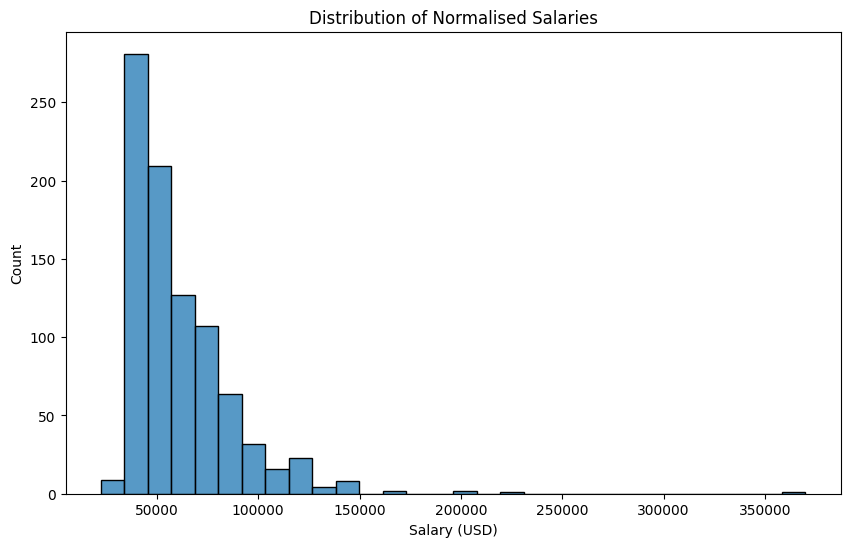

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="NormalisedSalary", bins=30)
plt.title("Distribution of Normalised Salaries")
plt.xlabel("Salary (USD)")
plt.ylabel("Count")
plt.show()

#### **Job Postings by Organization**

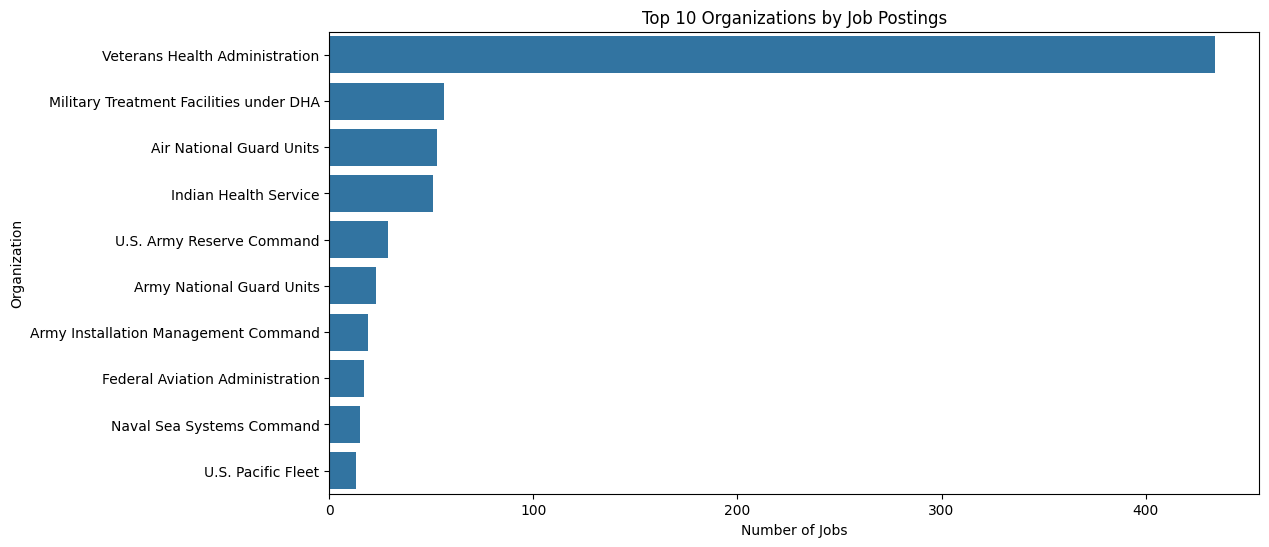

In [17]:
plt.figure(figsize=(12, 6))
top_orgs = df["Organization"].value_counts().head(10)
sns.barplot(x=top_orgs.values, y=top_orgs.index)
plt.title("Top 10 Organizations by Job Postings")
plt.xlabel("Number of Jobs")
plt.ylabel("Organization")
plt.show()

#### **Job Postings Over Time**

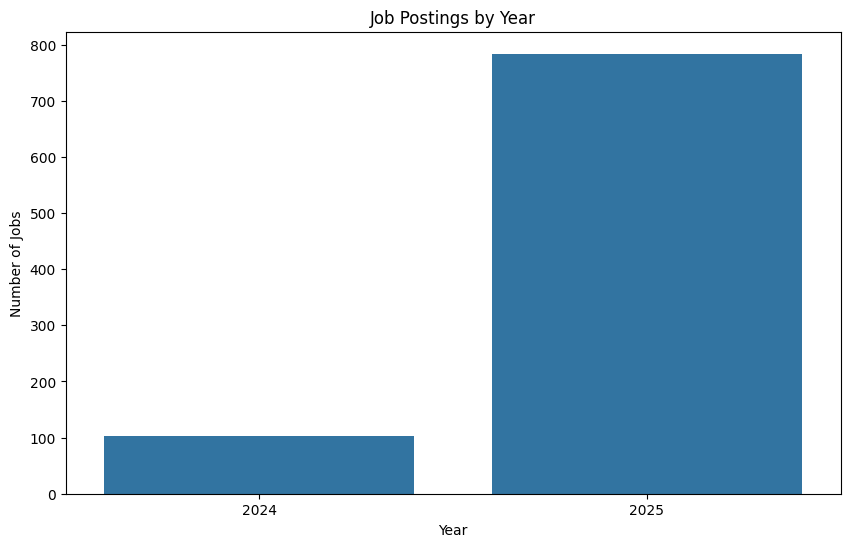

In [18]:
df["PublicationYear"] = df["PublicationDate"].dt.year
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="PublicationYear")
plt.title("Job Postings by Year")
plt.xlabel("Year")
plt.ylabel("Number of Jobs")
plt.show()

#### **Remote Work Eligibility**

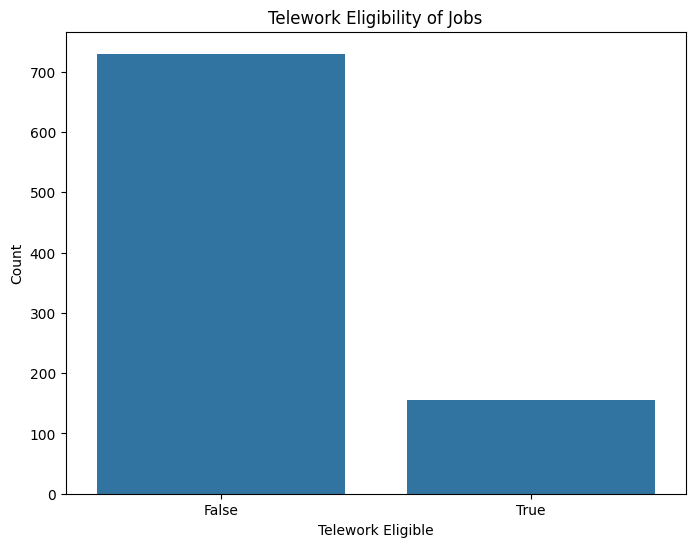

In [19]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="TeleworkEligible")
plt.title("Telework Eligibility of Jobs")
plt.xlabel("Telework Eligible")
plt.ylabel("Count")
plt.show()

#### **Hiring Path Distribution**

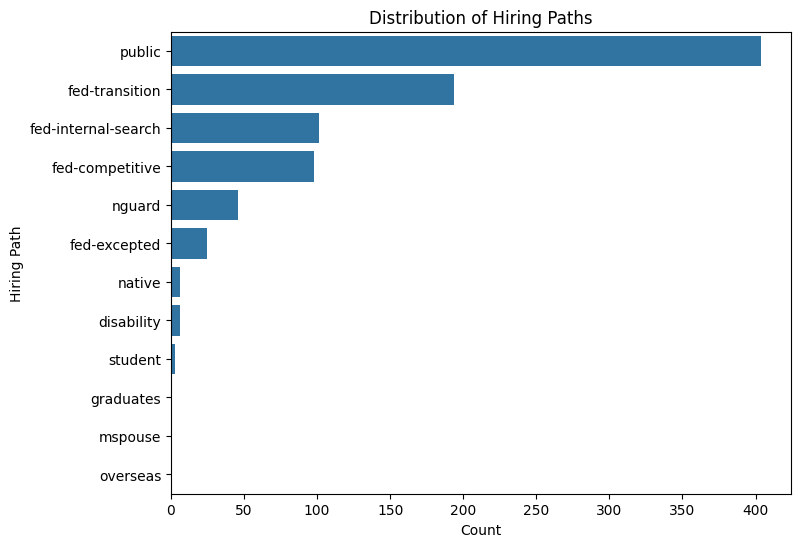

In [20]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, y="HiringPath", order=df["HiringPath"].value_counts().index) 
plt.title("Distribution of Hiring Paths")
plt.xlabel("Count") 
plt.ylabel("Hiring Path")
plt.show()